# ImageChange Decoder — 2025-10-09

Question: Does the population encode image changes differently from non-changes?

Analysis summary:
- Linear SVM decoders on population activity using ISI averages and time-resolved bins.
- Cross-validated accuracy versus shuffled-label controls evaluated per session.


## Workflow

1. Load aligned trial data via `modules.ReadResults` and `utils.get_neu_trial`.
2. Build a per-trial table mapping stimuli to orientation transitions.
3. Train linear SVM decoders (pooled ISI average and 100 ms time bins).
4. Compare decoder accuracy to label-shuffled controls and visualise example sessions.


In [1]:
import copy
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle


from session_configs import (
    session_config_YH02VT,
    session_config_YH14SC,
    session_config_YH19VT,
    session_config_YH21SC,
)
from modules.ReadResults import read_ops, read_all, read_neural_trials, read_masks
from modules.Alignment import run_get_stim_response
from modules import Trialization
from utils import get_neu_trial, get_frame_idx_from_time, pick_trial


plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(suppress=True)
from modeling.decoding import binary_decoder_cv, binary_timecourse_decoding, multiclass_decoder_cv, multiclass_timecourse_decoding


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
DATA_ROOT = Path('results')
RANDOM_STATE = 0
BIN_WIDTH_MS = 100.0
TIME_WINDOW_MS = (-500.0, 2000.0)

SHUFFLE_BASELINE = True
TRIAL_PARAM = [[2,3,4,5,-2,-3,-4,-5], [0, 1], None, None, [0], [0]]
LABEL_MAP = {-1: 'Exc', 0: 'Inh_VIP', 1: 'Inh_SST'}
BLOCK_LABELS = {0: 'Short', 1: 'Long'}

BASE_CONFIGS = {
    'YH02VT': session_config_YH02VT,
    # 'YH14SC': session_config_YH14SC,
    'YH19VT': session_config_YH19VT,
    # 'YH21SC': session_config_YH21SC,
}

TARGET_SESSIONS = {
    # Set to a list of session folder names to restrict, or None to include every available session on disk.
    'YH02VT': ['VTYH02_PPC_20250228_1451ShortLong'],
    # 'YH14SC': None,
    'YH19VT' : ['YH19VT_V1_20250421_1451ShortLong']
    # 'YH21SC': None,
}


In [3]:
def filter_session_config(template_cfg, target_sessions=None, data_root=DATA_ROOT):
    cfg = copy.deepcopy(template_cfg)
    available = {}
    targets = None if target_sessions is None else set(target_sessions)
    for session_name, tag in template_cfg['list_session_name'].items():
        if targets is not None and session_name not in targets:
            continue
        session_path = data_root / template_cfg['session_folder'] / session_name
        if session_path.is_dir():
            available[session_name] = tag
    cfg['list_session_name'] = available
    return cfg

def build_selected_configs(base_configs, target_map, data_root=DATA_ROOT):
    selected = []
    for subject, template in base_configs.items():
        targets = target_map.get(subject)
        cfg = filter_session_config(template, targets, data_root=data_root)
        if cfg['list_session_name']:
            selected.append(cfg)
    return selected

def combine_session_config_list(session_config_list):
    combined = copy.deepcopy(session_config_list)
    data_paths = []
    session_name_map = {}
    session_entries = []
    for cfg in combined['list_config']:
        folder = cfg['session_folder']
        for session_name, tag in cfg['list_session_name'].items():
            data_paths.append(str(Path('results') / folder / session_name))
            session_name_map[session_name] = tag
            session_entries.append({
                'subject': folder,
                'session': session_name,
                'tag': tag,
            })
    combined['list_session_data_path'] = data_paths
    combined['list_session_name'] = session_name_map
    return combined, session_entries

def infer_cell_type(labels):
    values, counts = np.unique(labels, return_counts=True)
    cell_type = 'Unknown'
    best_count = -1
    for value, count in zip(values, counts):
        label_name = LABEL_MAP.get(int(value))
        if label_name is not None and count > best_count:
            cell_type = label_name
            best_count = count
    return cell_type


In [4]:
def compute_trial_metadata(stim_labels):
    stim_labels = np.asarray(stim_labels)
    codes = stim_labels[:, 2].astype(int)
    base_codes = sorted({abs(code) for code in codes if abs(code) >= 2})
    if not base_codes:
        return pd.DataFrame(columns=['trial_index', 'label_code', 'orientation_idx', 'from_orientation_idx', 'is_transition', 'block_type', 'stim_start_ms', 'stim_end_ms', 'pair_label'])
    orientation_map = {code: idx for idx, code in enumerate(base_codes, start=1)}
    rows = []
    last_ori_idx = None
    repeat_count = 0
    for trial_idx, code in enumerate(codes):
        block_type = int(stim_labels[trial_idx, 3])
        if code == -1:
            if last_ori_idx is None:
                continue
            ori_idx = last_ori_idx
            from_idx = last_ori_idx
            is_transition = False
        else:
            ori_key = abs(code)
            if ori_key not in orientation_map:
                continue
            ori_idx = orientation_map[ori_key]
            from_idx = last_ori_idx if last_ori_idx is not None else ori_idx
            is_transition = bool(code < 0)
        if is_transition:
            repeat_count = 0
            pair_label = f'ori{int(from_idx)}->ori{int(ori_idx)}'
        else:
            repeat_count += 1
            pair_label = f'repeat_ori{int(ori_idx)}'
        rows.append({
            'trial_index': int(trial_idx),
            'label_code': int(code),
            'orientation_idx': int(ori_idx),
            'from_orientation_idx': int(from_idx),
            'is_transition': is_transition,
            'block_type': block_type,
            'stim_start_ms': float(stim_labels[trial_idx, 0]),
            'stim_end_ms': float(stim_labels[trial_idx, 1]),
            'pair_label': pair_label,
            'repeat_count': repeat_count,
        })
        last_ori_idx = ori_idx
    return pd.DataFrame(rows)

def prepare_session_dataset(neu_session, stim_labels, post_isi, neu_time, selected_indices=None):
    trial_meta = compute_trial_metadata(stim_labels)
    if trial_meta.empty:
        return None
    if selected_indices is None:
        selected_indices = np.arange(neu_session.shape[0])
    selected_indices = np.asarray(selected_indices)
    idx_map = {orig: pos for pos, orig in enumerate(selected_indices)}
    trial_meta = trial_meta[trial_meta['trial_index'].isin(idx_map)].copy()
    if trial_meta.empty:
        return None
    trial_meta['selected_index'] = trial_meta['trial_index'].map(idx_map)
    trial_meta = trial_meta.dropna(subset=['selected_index']).sort_values('selected_index').reset_index(drop=True)
    trial_meta['selected_index'] = trial_meta['selected_index'].astype(int)
    post_isi = np.asarray(post_isi).reshape(-1)
    neu_time = np.asarray(neu_time)
    features = []
    valid_idx = []
    trial_indices = []
    stim_durations = trial_meta['stim_end_ms'] - trial_meta['stim_start_ms']
    for row_idx, row in trial_meta.iterrows():
        selected_idx = int(row['selected_index'])
        if selected_idx >= neu_session.shape[0] or selected_idx >= post_isi.size:
            continue
        stim_duration = float(stim_durations.iloc[row_idx])
        isi = float(post_isi[selected_idx])
        if not np.isfinite(isi) or isi <= 0:
            continue
        left = stim_duration
        right = stim_duration + isi
        l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, left, right)
        r_idx = min(r_idx, neu_session.shape[-1])
        if r_idx - l_idx < 2:
            continue
        trace = neu_session[selected_idx, :, l_idx:r_idx]
        if np.all(np.isnan(trace)):
            continue
        feature = np.nanmean(trace, axis=-1)
        if not np.all(np.isfinite(feature)):
            continue
        features.append(feature)
        valid_idx.append(row_idx)
        trial_indices.append(selected_idx)
    if not features:
        return None
    trial_meta_valid = trial_meta.iloc[valid_idx].reset_index(drop=True).copy()
    trial_meta_valid['feature_trial_index'] = trial_indices
    trial_meta_valid['stim_duration_ms'] = trial_meta_valid['stim_end_ms'] - trial_meta_valid['stim_start_ms']
    trial_meta_valid['post_isi_ms'] = [float(post_isi[idx]) for idx in trial_indices]
    X_isi = np.stack(features)
    trial_neu = neu_session[trial_meta_valid['feature_trial_index'].to_numpy(), :, :]
    return {
        'meta': trial_meta_valid,
        'X_isi': X_isi,
        'trial_neu': trial_neu,
        'neu_time': neu_time,
    }


In [5]:
def plot_timecourse(ax, df):
    if df.empty:
        ax.text(0.5, 0.5, 'No timecourse data', ha='center', va='center', transform=ax.transAxes)
        return

    color_iter = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0']))
    handled_labels = set()

    for block_label, block_df in df.groupby('block_label'):
        block_df = block_df.sort_values('time_center_ms')
        color = next(color_iter)
        ax.plot(block_df['time_center_ms'], block_df['accuracy_mean'],
                label=f'{block_label} decoder', color=color)
        if np.any(np.isfinite(block_df['accuracy_sem'])):
            lower = block_df['accuracy_mean'] - block_df['accuracy_sem']
            upper = block_df['accuracy_mean'] + block_df['accuracy_sem']
            ax.fill_between(block_df['time_center_ms'], lower, upper, color=color, alpha=0.2)
        chance_values = block_df['chance_mean']
        chance_sem = block_df['chance_sem']
        if np.isfinite(chance_values).any():
            chance_label = f'{block_label} shuffled'
        else:
            chance_label = None
            ax.plot(block_df['time_center_ms'], chance_values, linestyle='--', color=color, alpha=0.6, label=chance_label)
            if np.any(np.isfinite(chance_sem)):
                lower = chance_values - chance_sem
                upper = chance_values + chance_sem
                ax.fill_between(block_df['time_center_ms'], lower, upper, color=color, alpha=0.15)
        handled_labels.add(f'{block_label} shuffled')

    ax.axhline(0.5, color='grey', linewidth=1, linestyle=':')
    ax.set_ylim(0.3, 1.0)


In [6]:
selected_configs = build_selected_configs(BASE_CONFIGS, TARGET_SESSIONS, data_root=DATA_ROOT)
if not selected_configs:
    raise RuntimeError('No sessions found. Update TARGET_SESSIONS or ensure data are in the results/ folder.')

session_config_list = {
    'list_config': selected_configs,
    'label_names': {str(k): v for k, v in LABEL_MAP.items()},
    'subject_name': 'ImageChangeDecoder',
    'output_filename': 'ImageChangeDecoder',
}

combined_config, session_entries = combine_session_config_list(session_config_list)
print(f'Selected {len(session_entries)} sessions:')
for entry in session_entries:
    print(f"- {entry['subject']}/{entry['session']} ({entry['tag']})")


Selected 2 sessions:
- YH02VT/VTYH02_PPC_20250228_1451ShortLong (short_long)
- YH19VT/YH19VT_V1_20250421_1451ShortLong (short_long)


In [7]:
list_ops = read_ops(combined_config['list_session_data_path'])
[list_labels, list_masks, list_neural_trials, list_move_offset] = read_all(combined_config, smooth=False)

alignment = run_get_stim_response('temp_ImageChangeDecoder', list_neural_trials, expected='none')
neu_time = alignment['neu_time']

_, neu_trial_data, _, _ = get_neu_trial(
    alignment,
    list_labels,
    alignment['list_stim_labels'],
    mean_sem=False,
    trial_param = [[2,3,4,5,-2,-3,-4,-5], [0, 1], None, None, [0], [0]], # all except oddball long
    cate=[-1,0,1]  
)
neu_list, stim_seq_list, camera_list, pre_isi_list, post_isi_list = neu_trial_data
print(f'Loaded {len(neu_list)} sessions with aligned neural data.')
selection_indices_list = []
for labels in alignment['list_stim_labels']:
    mask = pick_trial(labels, *TRIAL_PARAM, frac=1)
    selection_indices_list.append(np.where(mask)[0])



Reading subject 1/2


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Reading subject 2/2


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Aligning trials for session 1/2


trials: 100%|██████████| 1990/1990 [00:00<00:00, 15286.15it/s]


Aligning trials for session 2/2


trials: 100%|██████████| 1990/1990 [00:00<00:00, 15227.33it/s]


Loaded 2 sessions with aligned neural data.


In [8]:
analysis1_records = []
timecourse_tables = []
session_results = {}

for idx, entry in enumerate(session_entries):
    session_key = f"{entry['subject']}/{entry['session']}"
    neu_session = np.asarray(neu_list[idx])
    stim_labels = np.asarray(alignment['list_stim_labels'][idx])
    post_isi = np.asarray(post_isi_list[idx])
    dataset = prepare_session_dataset(neu_session, stim_labels, post_isi, neu_time, selection_indices_list[idx])
    if dataset is None:
        print(f'Skipping {session_key}: insufficient valid trials after filtering.')
        continue
    y = dataset['meta']['is_transition'].astype(int).to_numpy()
    metrics = binary_decoder_cv(
        dataset['X_isi'],
        y,
        n_splits=5,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    if metrics is None:
        print(f'Skipping {session_key}: not enough trials per class for cross-validation.')
        continue
    record = {
        'precision_mean': metrics['precision_mean'],
        'precision_sem': metrics['precision_sem'],
        'recall_mean': metrics['recall_mean'],
        'recall_sem': metrics['recall_sem'],
        'f1_mean': metrics['f1_mean'],
        'f1_sem': metrics['f1_sem'],
        'confusion_matrix': metrics['confusion_matrix'].tolist(),
        'subject': entry['subject'],
        'session': entry['session'],
        'session_key': session_key,
        'task_tag': entry['tag'],
        'n_trials': int(dataset['X_isi'].shape[0]),
        'n_neurons': int(dataset['X_isi'].shape[1]),
        'change_fraction': float(y.mean()),
        'accuracy_mean': metrics['mean_acc'],
        'accuracy_sem': metrics['sem_acc'],
        'chance_mean': metrics['mean_chance'],
        'chance_sem': metrics['sem_chance'],
        'n_splits': metrics['n_splits'],
    }
    analysis1_records.append(record)
    session_results[session_key] = {
        'dataset': dataset,
        'metrics_single': metrics,
    }
    timecourse_df = binary_timecourse_decoding(
        dataset['trial_neu'],
        neu_time,
        y,
        block_labels=dataset['meta']['block_type'].to_numpy(),
        bin_width_ms=BIN_WIDTH_MS,
        window=TIME_WINDOW_MS,
        n_splits=5,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    if not timecourse_df.empty:
        block_codes = timecourse_df['block_type'].astype(int)
        block_labels = block_codes.map(BLOCK_LABELS).fillna(block_codes.astype(str))
        timecourse_df = timecourse_df.assign(
            session=session_key,
            subject=entry['subject'],
            block_label=block_labels,
        )
        timecourse_tables.append(timecourse_df)
    else:
        print(f'No valid timecourse windows for {session_key}.')

analysis1_df = pd.DataFrame(analysis1_records)
analysis1_df = analysis1_df.sort_values(['subject', 'session']).reset_index(drop=True)
analysis1_df


,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,confusion_matrix,subject,session,session_key,task_tag,n_trials,n_neurons,change_fraction,accuracy_mean,accuracy_sem,chance_mean,chance_sem,n_splits
0,0.036603,0.005349,0.566667,0.10000,0.068727,0.010152,"[[455, 440], [13, 17]]",YH02VT,VTYH02_PPC_20250228_1451ShortLong,YH02VT/VTYH02_PPC_20250228_1451ShortLong,short_long,1848,95,0.033009,0.510270,0.020051,0.497297,0.022156,5
1,0.040853,0.008245,0.533333,0.08165,0.075847,0.015041,"[[510, 390], [14, 16]]",YH19VT,YH19VT_V1_20250421_1451ShortLong,YH19VT/YH19VT_V1_20250421_1451ShortLong,short_long,1859,265,0.033889,0.565591,0.025750,0.490323,0.031780,5


In [9]:
metrics_cols = ['accuracy_mean', 'chance_mean', 'precision_mean', 'recall_mean', 'f1_mean']
metrics_sem_cols = ['accuracy_sem', 'chance_sem', 'precision_sem', 'recall_sem', 'f1_sem']
metrics_df = analysis1_df[['session_key'] + metrics_cols + metrics_sem_cols].copy()
metrics_df


,session_key,accuracy_mean,chance_mean,precision_mean,recall_mean,f1_mean,accuracy_sem,chance_sem,precision_sem,recall_sem,f1_sem
0,YH02VT/VTYH02_PPC_20250228_1451ShortLong,0.510270,0.497297,0.036603,0.566667,0.068727,0.020051,0.022156,0.005349,0.10000,0.010152
1,YH19VT/YH19VT_V1_20250421_1451ShortLong,0.565591,0.490323,0.040853,0.533333,0.075847,0.025750,0.031780,0.008245,0.08165,0.015041


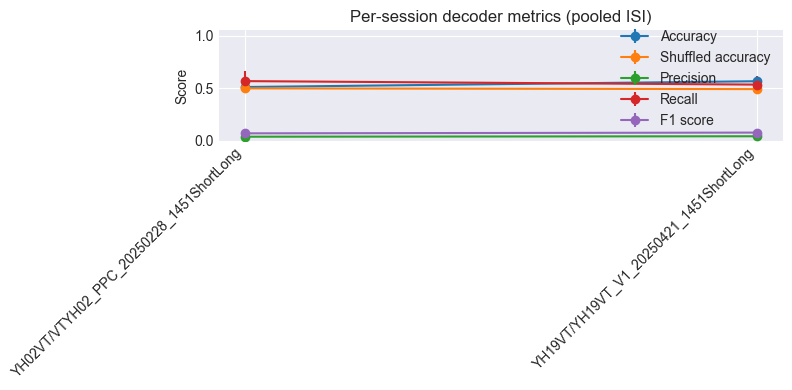

In [10]:
if not metrics_df.empty:
    sessions = metrics_df['session_key']
    x_pos = np.arange(len(sessions))
    label_map = {
        'accuracy_mean': 'Accuracy',
        'chance_mean': 'Shuffled accuracy',
        'precision_mean': 'Precision',
        'recall_mean': 'Recall',
        'f1_mean': 'F1 score',
    }
    fig, ax = plt.subplots(figsize=(8, 4))
    for metric, sem_col in zip(metrics_cols, metrics_sem_cols):
        label = label_map.get(metric, metric.replace('_mean', '').replace('_', ' ').title())
        ax.errorbar(x_pos, metrics_df[metric], yerr=metrics_df[sem_col], fmt='o-', label=label)
    ax.set_ylabel('Score')
    ax.set_ylim(0.0, 1.05)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sessions, rotation=45, ha='right')
    ax.legend(loc='lower right')
    ax.set_title('Per-session decoder metrics (pooled ISI)')
    plt.tight_layout()
    plt.show()


In [11]:
# Pooled within-session decoder (pool trials across short+long; do NOT pool across sessions)
pooled_rows = []
for session_key, payload in session_results.items():
    ds = payload['dataset']
    X = ds['X_isi']
    y = ds['meta']['is_transition'].astype(int).to_numpy()
    if np.unique(y).size < 2 or (np.bincount(y).min() < 2):
        print(f'Skipping {session_key}: not enough trials per class.')
        continue
    metrics = binary_decoder_cv(
        X, y,
        n_splits=20,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    pooled_rows.append({
        'session_key': session_key,
        'n_trials': int(X.shape[0]),
        'n_neurons': int(X.shape[1]),
        'change_fraction': float(y.mean()),
        'accuracy_mean': metrics['mean_acc'],
        'accuracy_sem': metrics['sem_acc'],
        'chance_mean': metrics['mean_chance'],
        'chance_sem': metrics['sem_chance'],
        'precision_mean': metrics.get('precision_mean'),
        'precision_sem': metrics.get('precision_sem'),
        'recall_mean': metrics.get('recall_mean'),
        'recall_sem': metrics.get('recall_sem'),
        'f1_mean': metrics.get('f1_mean'),
        'f1_sem': metrics.get('f1_sem'),
        'n_splits': metrics['n_splits'],
        'confusion_matrix': metrics['confusion_matrix'].tolist(),
    })

pooled_per_session = pd.DataFrame(pooled_rows)
pooled_per_session



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 95 and the array at index 1 has size 265

In [ ]:
if 'pooled_summary' in locals():
    pooled_metrics_display = pooled_summary[['n_trials', 'change_fraction', 'accuracy_mean', 'accuracy_sem', 'chance_mean', 'chance_sem', 'precision_mean', 'precision_sem', 'recall_mean', 'recall_sem', 'f1_mean', 'f1_sem']].copy()
    pooled_metrics_display


In [15]:
if 'pooled_summary' in locals():
    cm = np.array(pooled_summary['confusion_matrix'].iloc[0])
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Repeat', 'Change'])
    ax.set_yticklabels(['Repeat', 'Change'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black')
    ax.set_title('Pooled confusion matrix')
    plt.tight_layout()
    plt.show()


In [13]:
timecourse_df_all = pd.concat(timecourse_tables, ignore_index=True) if timecourse_tables else pd.DataFrame()
timecourse_df_all.head()


,block_type,time_start_ms,time_center_ms,time_stop_ms,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,n_splits,session,subject,block_label
0,0,-500.0,-450.0,-400.0,0.509677,0.027330,0.443011,0.041422,0.023668,0.007936,0.333333,0.105409,0.044189,0.014757,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
1,0,-400.0,-350.0,-300.0,0.458065,0.008736,0.524731,0.024378,0.030493,0.013013,0.533333,0.226078,0.057686,0.024608,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
2,0,-300.0,-250.0,-200.0,0.496774,0.010425,0.529032,0.035402,0.025782,0.003785,0.400000,0.066667,0.048434,0.007165,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
3,0,-200.0,-150.0,-100.0,0.445161,0.028571,0.453763,0.038077,0.031274,0.005126,0.533333,0.081650,0.059057,0.009627,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
4,0,-100.0,-50.0,0.0,0.509677,0.019414,0.503226,0.018121,0.042485,0.005711,0.666667,0.105409,0.079837,0.010809,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short


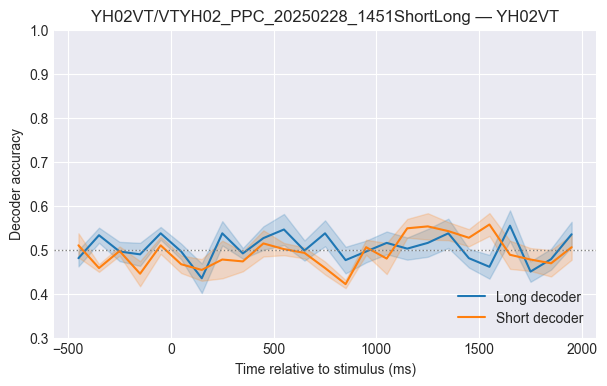

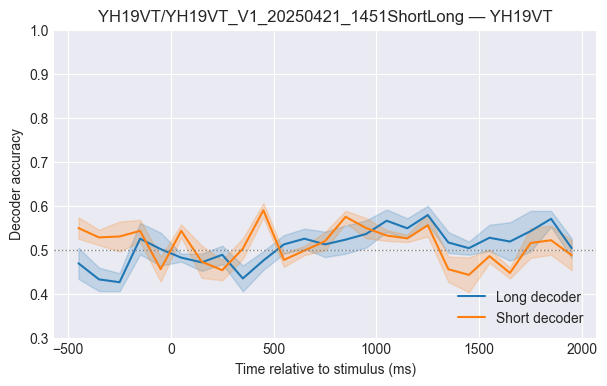

In [14]:
#Version with cell type for later use
# example_sessions = {}
# for record in analysis1_records:
#     ct = record['cell_type']
#     key = record['session_key']
#     if ct not in example_sessions:
#         example_sessions[ct] = key

# for cell_type, session_key in example_sessions.items():
#     if session_key not in session_results:
#         continue
#     df_session = timecourse_df_all[timecourse_df_all['session'] == session_key]
#     if df_session.empty:
#         continue
#     fig, ax = plt.subplots(figsize=(7, 4))
#     plot_timecourse(ax, df_session)
#     ax.set_title(f'{session_key} — {cell_type}')
#     ax.set_xlabel('Time relative to stimulus (ms)')
#     ax.set_ylabel('Decoder accuracy')
#     ax.legend(loc='lower right')
#     plt.show()
example_sessions = {}  # use the first session per subject
for record in analysis1_records:
    subject = record['subject']
    key = record['session_key']
    if subject not in example_sessions:
        example_sessions[subject] = key

for subject, session_key in example_sessions.items():
    if session_key not in session_results:
        continue
    df_session = timecourse_df_all[timecourse_df_all['session'] == session_key]
    if df_session.empty:
        continue
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_timecourse(ax, df_session)
    ax.set_title(f'{session_key} — {subject}')
    ax.set_xlabel('Time relative to stimulus (ms)')
    ax.set_ylabel('Decoder accuracy')
    ax.legend(loc='lower right')
    plt.show()


In [ ]:
if not timecourse_df_all.empty:
    summary_timecourse = (
        timecourse_df_all
        .groupby([
            #'cell_type', 
        'block_label', 'time_center_ms'])
        [['accuracy_mean', 'chance_mean']]
        .mean()
        .reset_index()
    )
    summary_timecourse.head()
else:
    print('No timecourse results to summarise.')


In [ ]:
timecourse_df_all

,block_type,time_start_ms,time_center_ms,time_stop_ms,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,n_splits,session,subject,block_label
0,0,-500.0,-450.0,-400.0,0.509677,0.027330,0.443011,0.041422,0.023668,0.007936,0.333333,0.105409,0.044189,0.014757,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
1,0,-400.0,-350.0,-300.0,0.458065,0.008736,0.524731,0.024378,0.030493,0.013013,0.533333,0.226078,0.057686,0.024608,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
2,0,-300.0,-250.0,-200.0,0.496774,0.010425,0.529032,0.035402,0.025782,0.003785,0.400000,0.066667,0.048434,0.007165,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
3,0,-200.0,-150.0,-100.0,0.445161,0.028571,0.453763,0.038077,0.031274,0.005126,0.533333,0.081650,0.059057,0.009627,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
4,0,-100.0,-50.0,0.0,0.509677,0.019414,0.503226,0.018121,0.042485,0.005711,0.666667,0.105409,0.079837,0.010809,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
5,0,0.0,50.0,100.0,0.466667,0.020001,0.453763,0.028530,0.028375,0.004981,0.466667,0.081650,0.053477,0.009359,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
6,0,100.0,150.0,200.0,0.453763,0.024614,0.526882,0.026557,0.038954,0.006842,0.666667,0.105409,0.073582,0.012838,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
7,0,200.0,250.0,300.0,0.477419,0.042822,0.513978,0.045544,0.016337,0.004297,0.266667,0.066667,0.030751,0.008044,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
8,0,300.0,350.0,400.0,0.473118,0.022555,0.520430,0.044801,0.020907,0.006656,0.333333,0.105409,0.039327,0.012513,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
9,0,400.0,450.0,500.0,0.513978,0.029721,0.520430,0.035271,0.036393,0.011173,0.533333,0.169967,0.068109,0.020941,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short


## Notes & Next Steps

- Review `analysis1_df` for per-session accuracy (mean ± SEM) and shuffled controls.
- `timecourse_df_all` stores decoder trajectories per session, block, and time bin for downstream pooling.
- Update `TARGET_SESSIONS` to target specific recordings or add new session folders as data arrive.


## Debug: Inspect data retrieval and labeling
Helper cells to step through one session outside of helper functions.


In [ ]:
debug_session_idx = 0  # change index to inspect other sessions
debug_session_entry = session_entries[debug_session_idx]
debug_session_key = f"{debug_session_entry['subject']}/{debug_session_entry['session']}"
print('Inspecting', debug_session_key)
#Each entry in neu_list would be a sessions neural/ DF/F recordings
#n_trials, n_neurons, n_frames DF/F around the trial 
debug_neu = np.asarray(neu_list[debug_session_idx])
debug_labels = np.asarray(alignment['list_stim_labels'][debug_session_idx])
debug_post_isi = np.asarray(post_isi_list[debug_session_idx])
debug_mask = pick_trial(debug_labels, *TRIAL_PARAM, frac=1)
debug_selected_idx = np.where(debug_mask)[0]
print('Selected trials:', debug_selected_idx[:10], '... total', debug_selected_idx.size)
print('Neural array shape after selection:', debug_neu.shape)


Inspecting YH02VT/VTYH02_PPC_20250228_1451ShortLong
Selected trials: [ 95  96  97  98  99 101 102 103 104 105] ... total 1848
Neural array shape after selection: (1848, 95, 600)


In [ ]:
debug_meta = compute_trial_metadata(debug_labels)
print('Original trial metadata rows:', len(debug_meta))
display(debug_meta.head())
debug_meta_sel = debug_meta.iloc[debug_selected_idx].copy()
debug_meta_sel['selected_index'] = np.arange(len(debug_meta_sel))
display(debug_meta_sel[['trial_index', 'label_code', 'is_transition', 'block_type']].head())
print('Transitions count:', debug_meta_sel['is_transition'].sum())
print('Repeats count:', (~debug_meta_sel['is_transition']).sum())


Original trial metadata rows: 1990


,trial_index,label_code,orientation_idx,from_orientation_idx,is_transition,block_type,stim_start_ms,stim_end_ms,pair_label,repeat_count
0,0,5,4,4,False,0,22708.0,22906.0,repeat_ori4,1
1,1,3,2,4,False,0,24575.0,24773.0,repeat_ori2,2
2,2,5,4,2,False,0,26795.0,26998.0,repeat_ori4,3
3,3,3,2,4,False,0,28966.0,29164.0,repeat_ori2,4
4,4,4,3,2,False,0,30666.0,30864.0,repeat_ori3,5


,trial_index,label_code,is_transition,block_type
95,95,4,False,0
96,96,4,False,0
97,97,4,False,0
98,98,4,False,0
99,99,4,False,0


Transitions count: 61
Repeats count: 1787


V1 session path: results/YH19VT/YH19VT_V1_20250421_1451ShortLong
Reading dff traces and voltage recordings
Correcting 2p camera trigger time


/opt/anaconda3/envs/suite2p/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/suite2p/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving trial data
Aligning trials for session 1/1


trials: 100%|██████████| 1990/1990 [00:00<00:00, 9507.34it/s] 


V1 decoder metrics:
{'mean_acc': 0.5771505376344085, 'precision_mean': 0.04736272054932063, 'recall_mean': 0.625, 'f1_mean': 0.08801687934152912}
Confusion matrix:
[[2072 1528]
 [  45   75]]


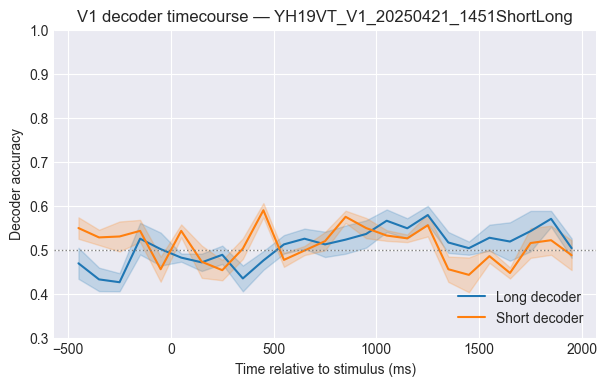

In [ ]:
# Decode change vs repeat for a single V1 session (YH19VT)V1
v1_session_folder = 'YH19VT'
v1_session_name = 'YH19VT_V1_20250421_1451ShortLong'  # adjust as needed
session_path = Path('results') / v1_session_folder / v1_session_name
print(f'V1 session path: {session_path}')
if not session_path.exists():
    raise FileNotFoundError(f'Missing session folder: {session_path}')

# Trialize (re-runs safely if data already present) and load raw trial data
ops_v1 = read_ops([str(session_path)])[0]
Trialization.run(ops_v1)
neural_trials_v1 = read_neural_trials(ops_v1, smooth=False)
labels_v1, *_ = read_masks(ops_v1)
list_labels_v1 = [labels_v1]

alignment_v1 = run_get_stim_response('temp_ImageChangeDecoder_V1', [neural_trials_v1], expected='none')
neu_time_v1 = alignment_v1['neu_time']

# Apply the same trial selection and category filters as PPC analysis
_, neu_trial_v1, _, _ = get_neu_trial(
    alignment_v1,
    list_labels_v1,
    alignment_v1['list_stim_labels'],
    mean_sem=False,
    trial_param=TRIAL_PARAM,
    cate=[-1, 0, 1],
)
neu_list_v1, _, _, _, post_isi_v1 = neu_trial_v1
neu_array_v1 = np.asarray(neu_list_v1[0])
stim_labels_v1 = np.asarray(alignment_v1['list_stim_labels'][0])
post_isi_v1 = np.asarray(post_isi_v1[0])

mask_v1 = pick_trial(stim_labels_v1, *TRIAL_PARAM, frac=1)
selection_idx_v1 = np.where(mask_v1)[0]
dataset_v1 = prepare_session_dataset(neu_array_v1, stim_labels_v1, post_isi_v1, neu_time_v1, selection_idx_v1)
if dataset_v1 is None:
    raise RuntimeError('No valid V1 trials after dataset preparation.')

y_v1 = dataset_v1['meta']['is_transition'].astype(int).to_numpy()
metrics_v1 = binary_decoder_cv(
    dataset_v1['X_isi'],
    y_v1,
    n_splits=20,
    random_state=RANDOM_STATE,
    shuffle_baseline=SHUFFLE_BASELINE,
    downsample=True,
)
print('V1 decoder metrics:')
print({k: metrics_v1[k] for k in ['mean_acc', 'precision_mean', 'recall_mean', 'f1_mean']})
print('Confusion matrix:')
print(metrics_v1['confusion_matrix'])

timecourse_v1 = binary_timecourse_decoding(
    dataset_v1['trial_neu'],
    neu_time_v1,
    y_v1,
    block_labels=dataset_v1['meta']['block_type'].to_numpy(),
    bin_width_ms=BIN_WIDTH_MS,
    window=TIME_WINDOW_MS,
    n_splits=5,
    random_state=RANDOM_STATE,
    shuffle_baseline=SHUFFLE_BASELINE,
    downsample=True,
)
if not timecourse_v1.empty:
    df_v1 = timecourse_v1.assign(block_label=timecourse_v1['block_type'].map(BLOCK_LABELS).fillna(timecourse_v1['block_type']))
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_timecourse(ax, df_v1)
    ax.set_title(f'V1 decoder timecourse — {v1_session_name}')
    ax.set_xlabel('Time relative to stimulus (ms)')
    ax.set_ylabel('Decoder accuracy')
    ax.legend(loc='lower right')
    plt.show()
else:
    print('No valid V1 time-course windows.')


In [ ]:
# Orientation decoding on V1 session (multiclass)
if 'dataset_v1' not in locals():
    raise RuntimeError('Run the V1 decoder cell first to create dataset_v1.')
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

ori_labels = dataset_v1['meta']['orientation_idx'].astype(int).to_numpy()
valid_mask = np.isfinite(ori_labels)
X_ori = dataset_v1['X_isi'][valid_mask]
y_ori = ori_labels[valid_mask]
unique_classes, class_counts = np.unique(y_ori, return_counts=True)
print('Orientation classes:', dict(zip(unique_classes, class_counts)))
if unique_classes.size < 2 or class_counts.min() < 2:
    raise RuntimeError('Not enough trials per orientation class for cross-validation.')
n_splits = min(20, int(class_counts.min()))
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
accs = []
chance_accs = []
conf_total = np.zeros((unique_classes.size, unique_classes.size), dtype=int)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_ori, y_ori)):
    X_train, X_test = X_ori[train_idx], X_ori[test_idx]
    y_train, y_test = y_ori[train_idx], y_ori[test_idx]
    pipeline = make_pipeline(
        StandardScaler(with_mean=True),
        LinearSVC(C=1.0, max_iter=5000, class_weight='balanced'),
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    conf_total += confusion_matrix(y_test, y_pred, labels=unique_classes)
    rng = np.random.default_rng(RANDOM_STATE + 2000 + fold_idx)
    y_perm = rng.permutation(y_train)
    pipeline_perm = make_pipeline(
        StandardScaler(with_mean=True),
        LinearSVC(C=1.0, max_iter=5000, class_weight='balanced'),
    )
    pipeline_perm.fit(X_train, y_perm)
    y_perm_pred = pipeline_perm.predict(X_test)
    chance_accs.append(accuracy_score(y_test, y_perm_pred))
accs = np.asarray(accs)
chance_accs = np.asarray(chance_accs)
acc_mean = accs.mean()
acc_sem = accs.std(ddof=1)/np.sqrt(len(accs)) if len(accs)>1 else np.nan
chance_mean = chance_accs.mean()
chance_sem = chance_accs.std(ddof=1)/np.sqrt(len(chance_accs)) if len(chance_accs)>1 else np.nan
print(f'Orientation decoding accuracy: {acc_mean:.3f} ± {acc_sem:.3f}')
print(f'Shuffled baseline: {chance_mean:.3f} ± {chance_sem:.3f}')
print('Confusion matrix (rows=true, cols=pred):')
conf_df = pd.DataFrame(conf_total, index=[f'ori{cls}' for cls in unique_classes], columns=[f'ori{cls}' for cls in unique_classes])
display(conf_df)


Orientation classes: {np.int64(1): np.int64(497), np.int64(2): np.int64(468), np.int64(3): np.int64(608), np.int64(4): np.int64(286)}
Orientation decoding accuracy: 0.693 ± 0.011
Shuffled baseline: 0.267 ± 0.011
Confusion matrix (rows=true, cols=pred):


,ori1,ori2,ori3,ori4
ori1,348,61,53,35
ori2,59,301,63,45
ori3,48,62,452,46
ori4,34,35,29,188


[{'subject': 'YH02VT',
  'session': 'VTYH02_PPC_20250228_1451ShortLong',
  'tag': 'short_long'}]

In [ ]:
# Build datasets per region (PPC sessions already processed; V1 optional)
region_data = {'PPC': [], 'V1': []}
for entry in session_entries:
    session_key = f"{entry['subject']}/{entry['session']}"
    if session_key not in session_results:
        continue
    dataset = session_results[session_key]['dataset']
    region_data['PPC'].append({
        'session_key': session_key,
        'dataset': dataset,
        'neu_time': neu_time,
    })

if 'dataset_v1' in locals():
    region_data['V1'].append({
        'session_key': f"{v1_session_folder}/{v1_session_name}",
        'dataset': dataset_v1,
        'neu_time': neu_time_v1,
    })
else:
    print('V1 dataset not found; run the V1 decoder cell first if needed.')
region_data


{'PPC': [{'session_key': 'YH02VT/VTYH02_PPC_20250228_1451ShortLong',
   'dataset': {'meta':       trial_index  label_code  orientation_idx  from_orientation_idx  \
    0              95           4                3                     4   
    1              96           4                3                     3   
    2              97           4                3                     3   
    3              98           4                3                     3   
    4              99           4                3                     3   
    ...           ...         ...              ...                   ...   
    1843         1985           3                2                     2   
    1844         1986           3                2                     2   
    1845         1987           3                2                     2   
    1846         1988           3                2                     2   
    1847         1989           3                2                     2   


In [ ]:
classification_suite = [
    # {
    #     'name': 'change_vs_repeat',
    #     'label': 'Change vs Repeat',
    #     'kind': 'binary',
    #     'label_fn': lambda meta: meta['is_transition'].astype(int),
    # },
    # {
    #     'name': 'orientation_to',
    #     'label': 'Orientation (current)',
    #     'kind': 'multiclass',
    #     'label_fn': lambda meta: meta['orientation_idx'],
    # },
    # {
    #     'name': 'orientation_from',
    #     'label': 'Orientation (previous)',
    #     'kind': 'multiclass',
    #     'label_fn': lambda meta: meta['from_orientation_idx'],
    # },
    {
        'name': 'change_pair',
        'label': 'Change pair / repeat class',
        'kind': 'multiclass',
        'label_fn': lambda meta: meta['pair_label'],
    },
]
suite_results = {}
for region, sessions in region_data.items():
    region_results = {}
    for task in classification_suite:
        print(f"Starting {region, task['label']} ")
        session_metrics = []
        timecourse_tables = []
        for sess in sessions:
            dataset = sess['dataset']
            meta = dataset['meta']
            try:
                labels_obj = task['label_fn'](meta)
            except KeyError:
                continue
            if task['kind'] == 'binary':
                y = np.asarray(labels_obj, dtype=int)
                if np.unique(y).size < 2:
                    continue
                X = dataset['X_isi']
                metrics = binary_decoder_cv(
                    X,
                    y,
                    n_splits=20,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                    downsample=True,
                )
                if metrics is None:
                    continue
                tc = binary_timecourse_decoding(
                    dataset['trial_neu'],
                    sess['neu_time'],
                    y,
                    block_labels=meta['block_type'].to_numpy(),
                    bin_width_ms=BIN_WIDTH_MS,
                    window=TIME_WINDOW_MS,
                    n_splits=20,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                    downsample=True,
                )
                class_labels = [0, 1]
            else:
                labels_series = pd.Series(labels_obj)
                mask = labels_series.notna()
                if mask.sum() < 2:
                    continue
                values = labels_series[mask]
                codes, uniques = pd.factorize(values)
                if np.unique(codes).size < 2:
                    continue
                X = dataset['X_isi'][mask.to_numpy()]
                y = codes
                print("starting multiclass decoder")
                metrics = multiclass_decoder_cv(
                    X,
                    y,
                    n_splits=10,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                )
                if metrics is None:
                    continue
                print("starting multiclass timecourse decoder")
                tc = multiclass_timecourse_decoding(
                    dataset['trial_neu'][mask.to_numpy()],
                    sess['neu_time'],
                    y,
                    block_labels=meta['block_type'].to_numpy()[mask.to_numpy()],
                    bin_width_ms=BIN_WIDTH_MS,
                    window=TIME_WINDOW_MS,
                    n_splits=5,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                )
                class_labels = [str(u) for u in uniques]
                metrics['class_labels'] = class_labels
            session_metrics.append({
                'session_key': sess['session_key'],
                'n_trials': int(X.shape[0]),
                'accuracy_mean': metrics['mean_acc'],
                'accuracy_sem': metrics['sem_acc'],
                'chance_mean': metrics['mean_chance'],
                'chance_sem': metrics['sem_chance'],
                'precision_mean': metrics.get('precision_mean'),
                'precision_sem': metrics.get('precision_sem'),
                'recall_mean': metrics.get('recall_mean'),
                'recall_sem': metrics.get('recall_sem'),
                'f1_mean': metrics.get('f1_mean'),
                'f1_sem': metrics.get('f1_sem'),
                'class_labels': class_labels,
            })
            if not tc.empty:
                tc = tc.assign(session=sess['session_key'], region=region, task=task['label'])
                timecourse_tables.append(tc)
        region_results[task['label']] = {
            'session_metrics': pd.DataFrame(session_metrics),
            'timecourse': pd.concat(timecourse_tables, ignore_index=True) if timecourse_tables else pd.DataFrame(),
        }
    suite_results[region] = region_results
suite_results


Starting ('PPC', 'Change pair / repeat class') 
starting multiclass decoder
starting multiclass timecourse decoder
Starting ('V1', 'Change pair / repeat class') 
starting multiclass decoder


{'PPC': {'Change pair / repeat class': {'session_metrics':                                 session_key  n_trials  accuracy_mean  \
   0  YH02VT/VTYH02_PPC_20250228_1451ShortLong      1848       0.183442   
   
      accuracy_sem  chance_mean  chance_sem  precision_mean  precision_sem  \
   0      0.005701     0.172078    0.012987        0.071676       0.003779   
   
      recall_mean  recall_sem  f1_mean    f1_sem  \
   0     0.088477    0.027599  0.06443  0.005532   
   
                                           class_labels  
   0  [repeat_ori3, ori3->ori4, repeat_ori4, ori4->o...  ,
   'timecourse': Empty DataFrame
   Columns: []
   Index: []}},
 'V1': {'Change pair / repeat class': {'session_metrics': Empty DataFrame
   Columns: []
   Index: [],
   'timecourse': Empty DataFrame
   Columns: []
   Index: []}}}

In [ ]:
block_name = {0: 'short', 1: 'long'}
for region, task_dict in suite_results.items():
    print(f'=== {region} ===')
    for task_label, payload in task_dict.items():
        df = payload['session_metrics']
        if df.empty:
            print(f'  {task_label}: no valid sessions')
            continue
        display(df)
        tc = payload['timecourse']
        if not tc.empty:
            fig, ax = plt.subplots(figsize=(7, 4))
            df_plot = (
                tc.groupby(['task','block_type','time_center_ms'])
                  .agg(
                      acc_mean=('accuracy_mean','mean'),
                      acc_sem=('accuracy_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                      chance_mean=('chance_mean','mean'),
                      chance_sem=('chance_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                  )
                  .reset_index()
            )
            color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0']))
            for block, sub in df_plot.groupby('block_type'):
                color = next(color_cycle)
                label_block = block_name.get(int(block), f'block {block}')
                ax.plot(sub['time_center_ms'], sub['acc_mean'], label=f'{task_label} {label_block}', color=color)
                ax.fill_between(sub['time_center_ms'], sub['acc_mean'] - sub['acc_sem'], sub['acc_mean'] + sub['acc_sem'], color=color, alpha=0.2)
                ax.plot(sub['time_center_ms'], sub['chance_mean'], linestyle='--', color=color, alpha=0.6)
                ax.fill_between(sub['time_center_ms'], sub['chance_mean'] - sub['chance_sem'], sub['chance_mean'] + sub['chance_sem'], color=color, alpha=0.15)
            ax.axhline(0.5, color='grey', linestyle=':', linewidth=1)
            ax.set_title(f'{region} – {task_label}')
            ax.set_xlabel('Time relative to stimulus (ms)')
            ax.set_ylabel('Accuracy')
            ax.legend(loc='lower right')
            plt.tight_layout()
            plt.show()


NameError: name 'suite_results' is not defined